In [2]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 150.0/150.0 MB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


sklearn: 1.2.1


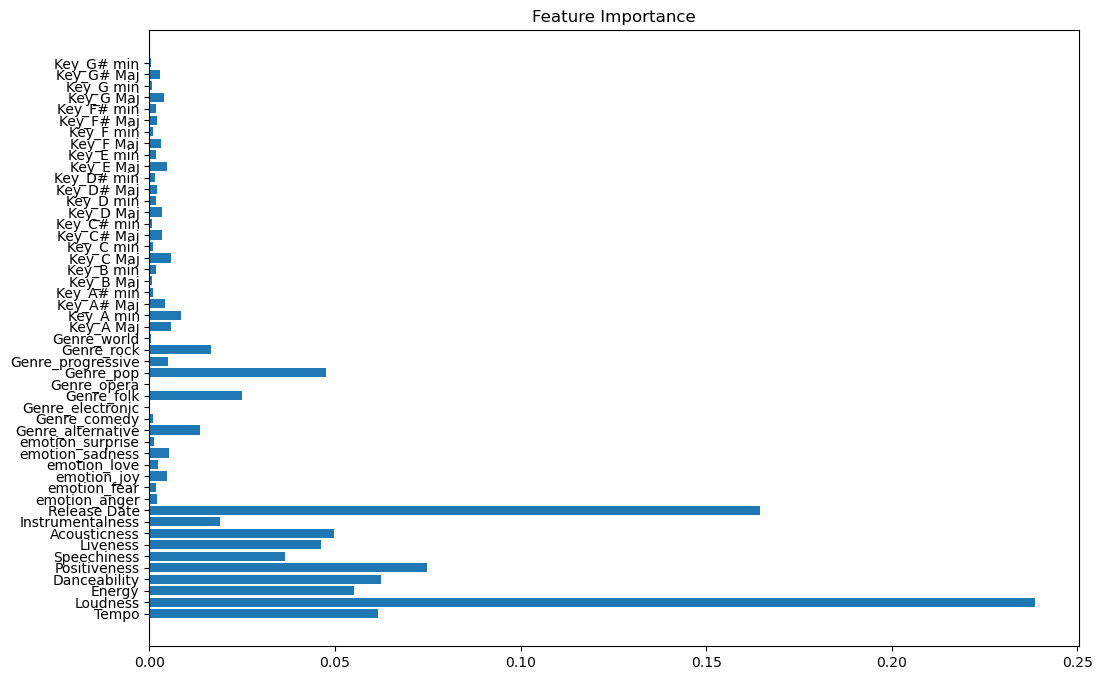

Random Forest:
  MSE: 257.94
  R²: 0.52

XGBoost:
  MSE: 303.03
  R²: 0.44



In [2]:
import pandas as pd
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('light_spotify_dataset.csv')
df=df.head(1000)

# Data preprocessing
# Convert categorical variables
df['Explicit'] = df['Explicit'].map({'Yes': 1, 'No': 0})

# Feature selection
features = ['emotion', 'Genre', 'Key', 'Tempo', 'Loudness', 'Energy', 
            'Danceability', 'Positiveness', 'Speechiness', 'Liveness',
            'Acousticness', 'Instrumentalness', 'Explicit', 'Release Date']
target = 'Popularity'

# Split data
X = df[features]
y = df[target]

# Preprocessing pipeline
categorical_features = ['emotion', 'Genre', 'Key']
numeric_features = ['Tempo', 'Loudness', 'Energy', 'Danceability', 
                   'Positiveness', 'Speechiness', 'Liveness',
                   'Acousticness', 'Instrumentalness', 'Release Date']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Models to try
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Train and evaluate models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'R2': r2}
    
    # Feature importance for Random Forest
    if name == "Random Forest":
        feature_names = (numeric_features + 
                         list(pipeline.named_steps['preprocessor']
                         .named_transformers_['cat']
                         .get_feature_names_out(categorical_features)))
        
        importances = pipeline.named_steps['model'].feature_importances_
        plt.figure(figsize=(12, 8))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance")
        plt.show()

# Display results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  MSE: {metrics['MSE']:.2f}")
    print(f"  R²: {metrics['R2']:.2f}")
    print()